In [195]:
import pandas as pd, numpy as np,matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import RFE

In [196]:
raw_data = pd.read_csv('premier_league_data_21_22.csv')

First, we format the data and define the variables we wish to use to predict with.

In [197]:
df =        raw_data[[

    'element_type', 'date', 'player_name', 'team_name', 'opponent_team_name', 'minutes', 'event', 'h_a',  #Identifiers

    'goals_scored','assists', 'clean_sheets','goals_conceded', 'own_goals', 'team_scored', 'team_conceded', 'yellow_cards','red_cards','penalties_missed','penalties_saved', 'saves','npg', 'wins', 'loses',    #Outcome metrics

    'ict_index', 'influence', 'creativity', 'bonus', 'threat','total_points',       #FPL metrics

    'shots', 'xG_player','xA', 'key_passes', 'xGChain', 'xGBuildup', 'npxGD', 'deep', 'deep_allowed', 'ppda_allowed_att', 'ppda_allowed_def', 'ppda_att', 'ppda_def' #Underlying metrics
    ]]
df.index.rename('entry',inplace=True)

In [198]:
df

,element_type,date,player_name,team_name,opponent_team_name,minutes,event,h_a,goals_scored,assists,...,key_passes,xGChain,xGBuildup,npxGD,deep,deep_allowed,ppda_allowed_att,ppda_allowed_def,ppda_att,ppda_def
entry,,,,,,,,,,,,,,,,,,,,,
0,1,2021-08-13,Bernd Leno,Arsenal,Brentford,90,1.0,a,0,0,...,0,0.097028,0.097028,-0.864330,10.0,7.0,290,18,127,22
1,1,2021-08-22,Bernd Leno,Arsenal,Chelsea,90,2.0,h,0,0,...,0,0.000000,0.000000,-3.011221,3.0,19.0,156,15,376,23
2,1,2021-08-28,Bernd Leno,Arsenal,Manchester City,90,3.0,a,0,0,...,0,0.000000,0.000000,-4.355925,0.0,14.0,91,18,365,7
3,1,2022-03-19,Bernd Leno,Arsenal,Aston Villa,90,30.0,a,0,0,...,0,0.092356,0.092356,0.835845,11.0,3.0,302,14,246,18
4,4,2021-08-22,Pierre-Emerick Aubameyang,Arsenal,Chelsea,29,2.0,h,0,0,...,0,0.039828,0.000000,-3.011221,3.0,19.0,156,15,376,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10450,3,2022-03-18,Chiquinho,Wolverhampton Wanderers,Leeds,1,30.0,h,0,0,...,0,0.059847,0.059847,-1.580280,8.0,6.0,251,30,272,20
10451,3,2022-04-02,Chiquinho,Wolverhampton Wanderers,Aston Villa,1,31.0,h,0,0,...,0,0.000000,0.000000,0.470120,4.0,8.0,266,22,268,22
10452,3,2022-05-07,Chiquinho,Wolverhampton Wanderers,Chelsea,19,36.0,a,0,2,...,2,0.541080,0.000000,0.624390,3.0,10.0,212,22,293,16


In [199]:
variables = ['goals_scored','assists', 'clean_sheets','goals_conceded', 'own_goals', 'team_scored', 'team_conceded', 'yellow_cards','red_cards','penalties_missed','penalties_saved', 'saves','npg', 'wins', 'loses',    #Outcome metrics
                                                                                                                                                   'ict_index', 'influence', 'creativity', 'bonus', 'threat',#'total_points',       #FPL metrics

'shots', 'xG_player','xA', 'key_passes', 'xGChain', 'xGBuildup', 'npxGD', 'deep', 'deep_allowed', 'ppda_allowed_att', 'ppda_allowed_def', 'ppda_att', 'ppda_def' #Underlying metrics
             ]

Dummy encoding for categorical feature:

(Was the match played at the player's home stadium or not?)

In [200]:
df['h_a'] = df['h_a'].apply(lambda x: 1 if x=='h' else 0)

/var/folders/s0/pp1d11617gx4jppd2zfq3pbm0000gp/T/ipykernel_62070/4034034874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['h_a'] = df['h_a'].apply(lambda x: 1 if x=='h' else 0)


We can now predict using a linear model.

As our data is given to us on a game-by-game basis, we want to use a players past average metrics to predict his current/future ones.

First, we need to decide on an optimal average rolling window:

In [201]:
def rolling_avg_df(df:pd.DataFrame,x:int):

    # Conduct a rolling average for the statistics for the past 'x' games, and shift the data by 1 to account for the fact we want to use past data to predict current game

    averaged_df = df.groupby('player_name')[variables].rolling(x).mean().groupby('player_name').shift(1).reset_index().sort_index().dropna().set_index('entry')

    #Now add back in the target variable and some other categorical variables for each match

    df_data = averaged_df.join(df[['h_a', 'total_points', 'element_type']]).drop(columns='player_name')

    #data is now in the correct format to be used as a prediction

    return df_data

In [210]:
def linear_model(df:pd.DataFrame, x:int, position:int):

    df_data = rolling_avg_df(df=df,x=x)


    # 'element_type' represents the position of the player.
    # 1,2,3,4 represent goalkeeper, defender, midfielder, attacker, respectively.

    positional_df = df_data[df_data['element_type'] == position].drop(columns='element_type')

    #Define target and feature dataframes
    pos_features_df = positional_df.drop(columns='total_points').values
    pos_target_df = positional_df['total_points'].values

    #Train the model

    model = LinearRegression().fit(pos_features_df,pos_target_df)

    #Find fitted values and add them to the original Dataframe

    positional_df['xpts'] = model.predict(pos_features_df)

    #Calculate SSE, SSR, Standard Error

    sse = sum((positional_df['total_points'] - positional_df['xpts']) ** 2)
    ssr = sum((positional_df['xpts'] - positional_df['total_points'].mean()) **2)
    sst = sse + ssr
    stderr = np.sqrt(sse / (len(positional_df) - 2))

    return sse,ssr,stderr

In [208]:
temp = [linear_model(df,i,3) for i in range(1,30)]
mid_sse = [i[0] for i in temp]
mid_ssr = [i[1] for i in temp]
mid_stderr = [i[2] for i in temp]

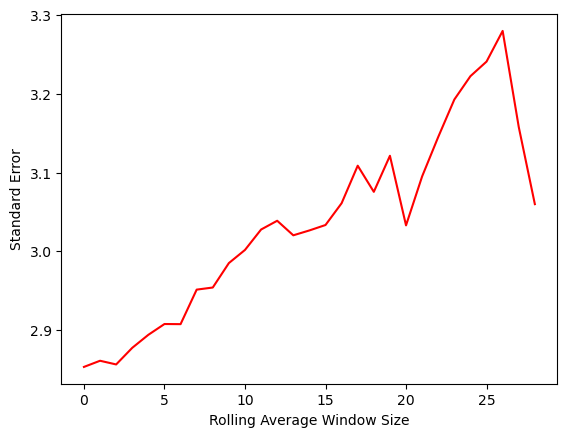

In [209]:
plt.figure(1)
plt.ylabel('Standard Error')
plt.xlabel('Rolling Average Window Size')
plt.plot(mid_stderr,'r')

It seems as if the optimal average is to use 3 games worth of past data to predict each gameweek.

The dataframe will look like this:

In [218]:
rolling_avg_df(df,3)

,goals_scored,assists,clean_sheets,goals_conceded,own_goals,team_scored,team_conceded,yellow_cards,red_cards,penalties_missed,...,npxGD,deep,deep_allowed,ppda_allowed_att,ppda_allowed_def,ppda_att,ppda_def,h_a,total_points,element_type
entry,,,,,,,,,,,,,,,,,,,,,
1919,0.000000,0.000000,0.000000,0.000000,0.000000,1.333333,0.666667,0.0,0.0,0.0,...,0.519649,6.000000,6.000000,317.333333,19.666667,208.666667,23.000000,1,2,4
9503,0.333333,0.333333,0.000000,1.666667,0.000000,3.333333,1.666667,0.0,0.0,0.0,...,0.614473,8.666667,5.333333,232.666667,17.000000,291.000000,20.666667,0,8,2
9504,0.000000,0.333333,0.333333,1.000000,0.000000,2.000000,1.000000,0.0,0.0,0.0,...,0.487847,5.666667,5.000000,246.666667,17.666667,286.666667,23.666667,1,1,2
9505,0.000000,0.333333,0.333333,1.333333,0.000000,1.000000,1.333333,0.0,0.0,0.0,...,-0.395098,6.333333,5.666667,227.333333,16.333333,289.666667,25.666667,0,2,2
9506,0.000000,0.000000,0.333333,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.0,...,-0.054424,4.333333,6.333333,234.666667,14.666667,270.333333,20.666667,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,0.000000,0.000000,0.000000,1.666667,0.000000,1.333333,1.666667,0.0,0.0,0.0,...,-0.520364,6.000000,5.000000,228.000000,23.000000,209.000000,22.666667,0,2,1
1542,0.000000,0.000000,0.000000,1.666667,0.000000,1.333333,1.666667,0.0,0.0,0.0,...,0.148651,6.000000,5.333333,209.000000,25.333333,204.666667,23.666667,1,2,1
1543,0.000000,0.000000,0.000000,1.333333,0.000000,0.666667,1.333333,0.0,0.0,0.0,...,-0.037826,5.333333,5.000000,201.666667,23.333333,215.666667,23.333333,1,3,1


Now for the ridge regression model, using a rolling average of 3


We will vary lambda and see whether this affects our results

In [211]:
def linear_ridge_model(df:pd.DataFrame, l:float, position:int):

    df_data = rolling_avg_df(df=df,x=3)


    positional_df = df_data[df_data['element_type'] == position].drop(columns='element_type')

    #Define target and feature dataframes
    pos_features_df = positional_df.drop(columns='total_points').values
    pos_target_df = positional_df['total_points'].values

    #Train the model

    model = Ridge(alpha=l).fit(pos_features_df,pos_target_df)

    #Find fitted values and add them to the original Dataframe

    positional_df['xpts'] = model.predict(pos_features_df)

    #Calculate SSE, SSR, Standard Error

    sse = sum((positional_df['total_points'] - positional_df['xpts']) ** 2)
    ssr = sum((positional_df['xpts'] - positional_df['total_points'].mean()) **2)
    sst = sse + ssr
    stderr = np.sqrt(sse / (len(positional_df) - 2))

    return sse,ssr,stderr

In [213]:
temp = [linear_ridge_model(df, i,3) for i in range(1, 30)]
mid_sse = [i[0] for i in temp]
mid_ssr = [i[1] for i in temp]
mid_stderr = [i[2] for i in temp]

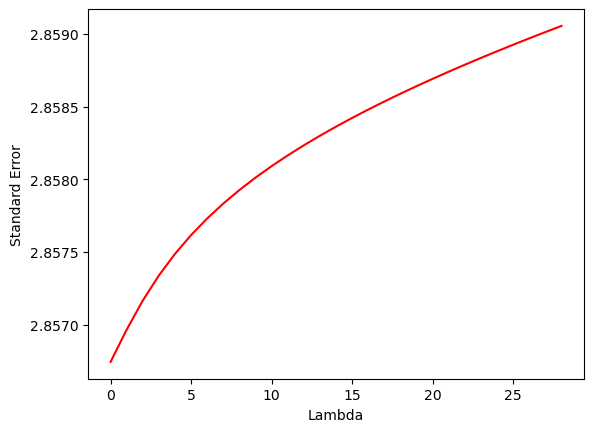

In [215]:
plt.figure(1)
plt.ylabel('Standard Error')
plt.xlabel('Lambda')
plt.plot(mid_stderr,'r')

Standard error increases as Lambda increases? ...